In [1]:
import os
os.chdir("..")

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.utils import summarize_depths_by_return_period
from production.metrics import metrics
from production.plots import plot_return_period_summary, plot_two_return_period_summaries


Load data

In [3]:
watershed_names = ["Trinity","Kanawha","Duwamish","Denton"]

In [4]:
#Load data
watersheds = {}

for wname in watershed_names:
    ws = Preprocessor.load(
        config_path=f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{wname}/config.json"
    )
    watersheds[wname] = ws

In [5]:
#Full Monte Carlo summary
base_dir = "/workspaces/Importance-Sampling-for-SST/data/1_interim"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

Trinity

In [75]:
watershed = watersheds["Trinity"]

In [168]:
#Sample
params = {
    "mu_x_narrow": watershed.watershed_stats["x"],  
    "mu_y_narrow": watershed.watershed_stats["y"],
    "mu_x_wide": watershed.domain_stats["x"],  
    "mu_y_wide": watershed.domain_stats["y"],
    "sd_x_narrow": watershed.watershed_stats["range_x"]*0.2,
    "sd_y_narrow": watershed.watershed_stats["range_y"]*0.2,
    "sd_x_wide": watershed.domain_stats["range_x"],
    "sd_y_wide": watershed.domain_stats["range_y"],
    "mix": 0.8,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=6_000,
    num_realizations=50,
)

mixture_samples = sampler.sample(data = watershed)

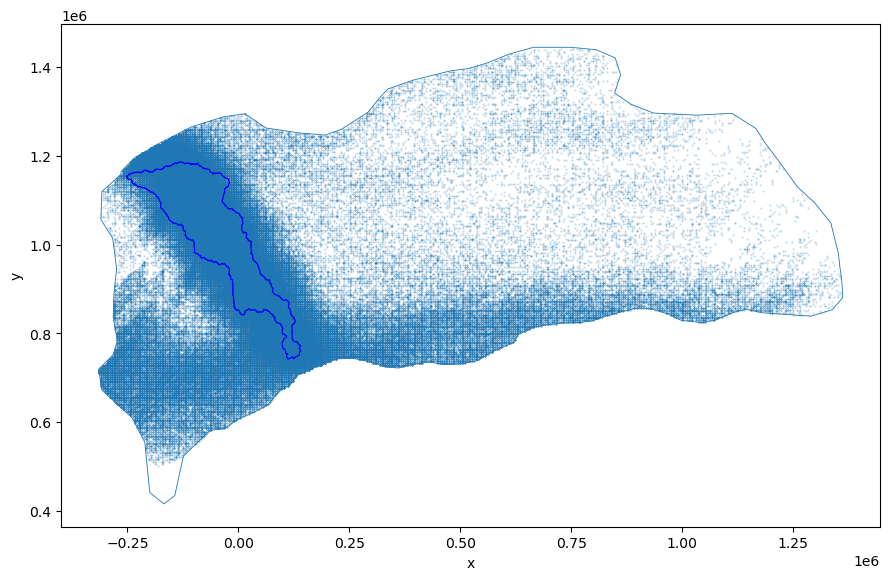

In [169]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
watershed.watershed_gdf.boundary.plot(ax=ax, linewidth=0.8, color='blue', label='Watershed')
plt.scatter(mixture_samples.newx, mixture_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [93]:
mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

In [94]:
mixture_summary = summarize_depths_by_return_period(
    df=mixture_depths,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
)

In [95]:
m = metrics(summaries["Trinity"],mixture_summary)
m

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_low,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high
0,1999,2.0,2000.0,0.021138,0.039717,0.104007,0.122327,0.087733,0.104156,-0.002696,...,-0.030128,-0.000758,0.009363,-0.004621,-0.018876,-0.042371,0.056375,-0.048252,0.06285,-0.042947


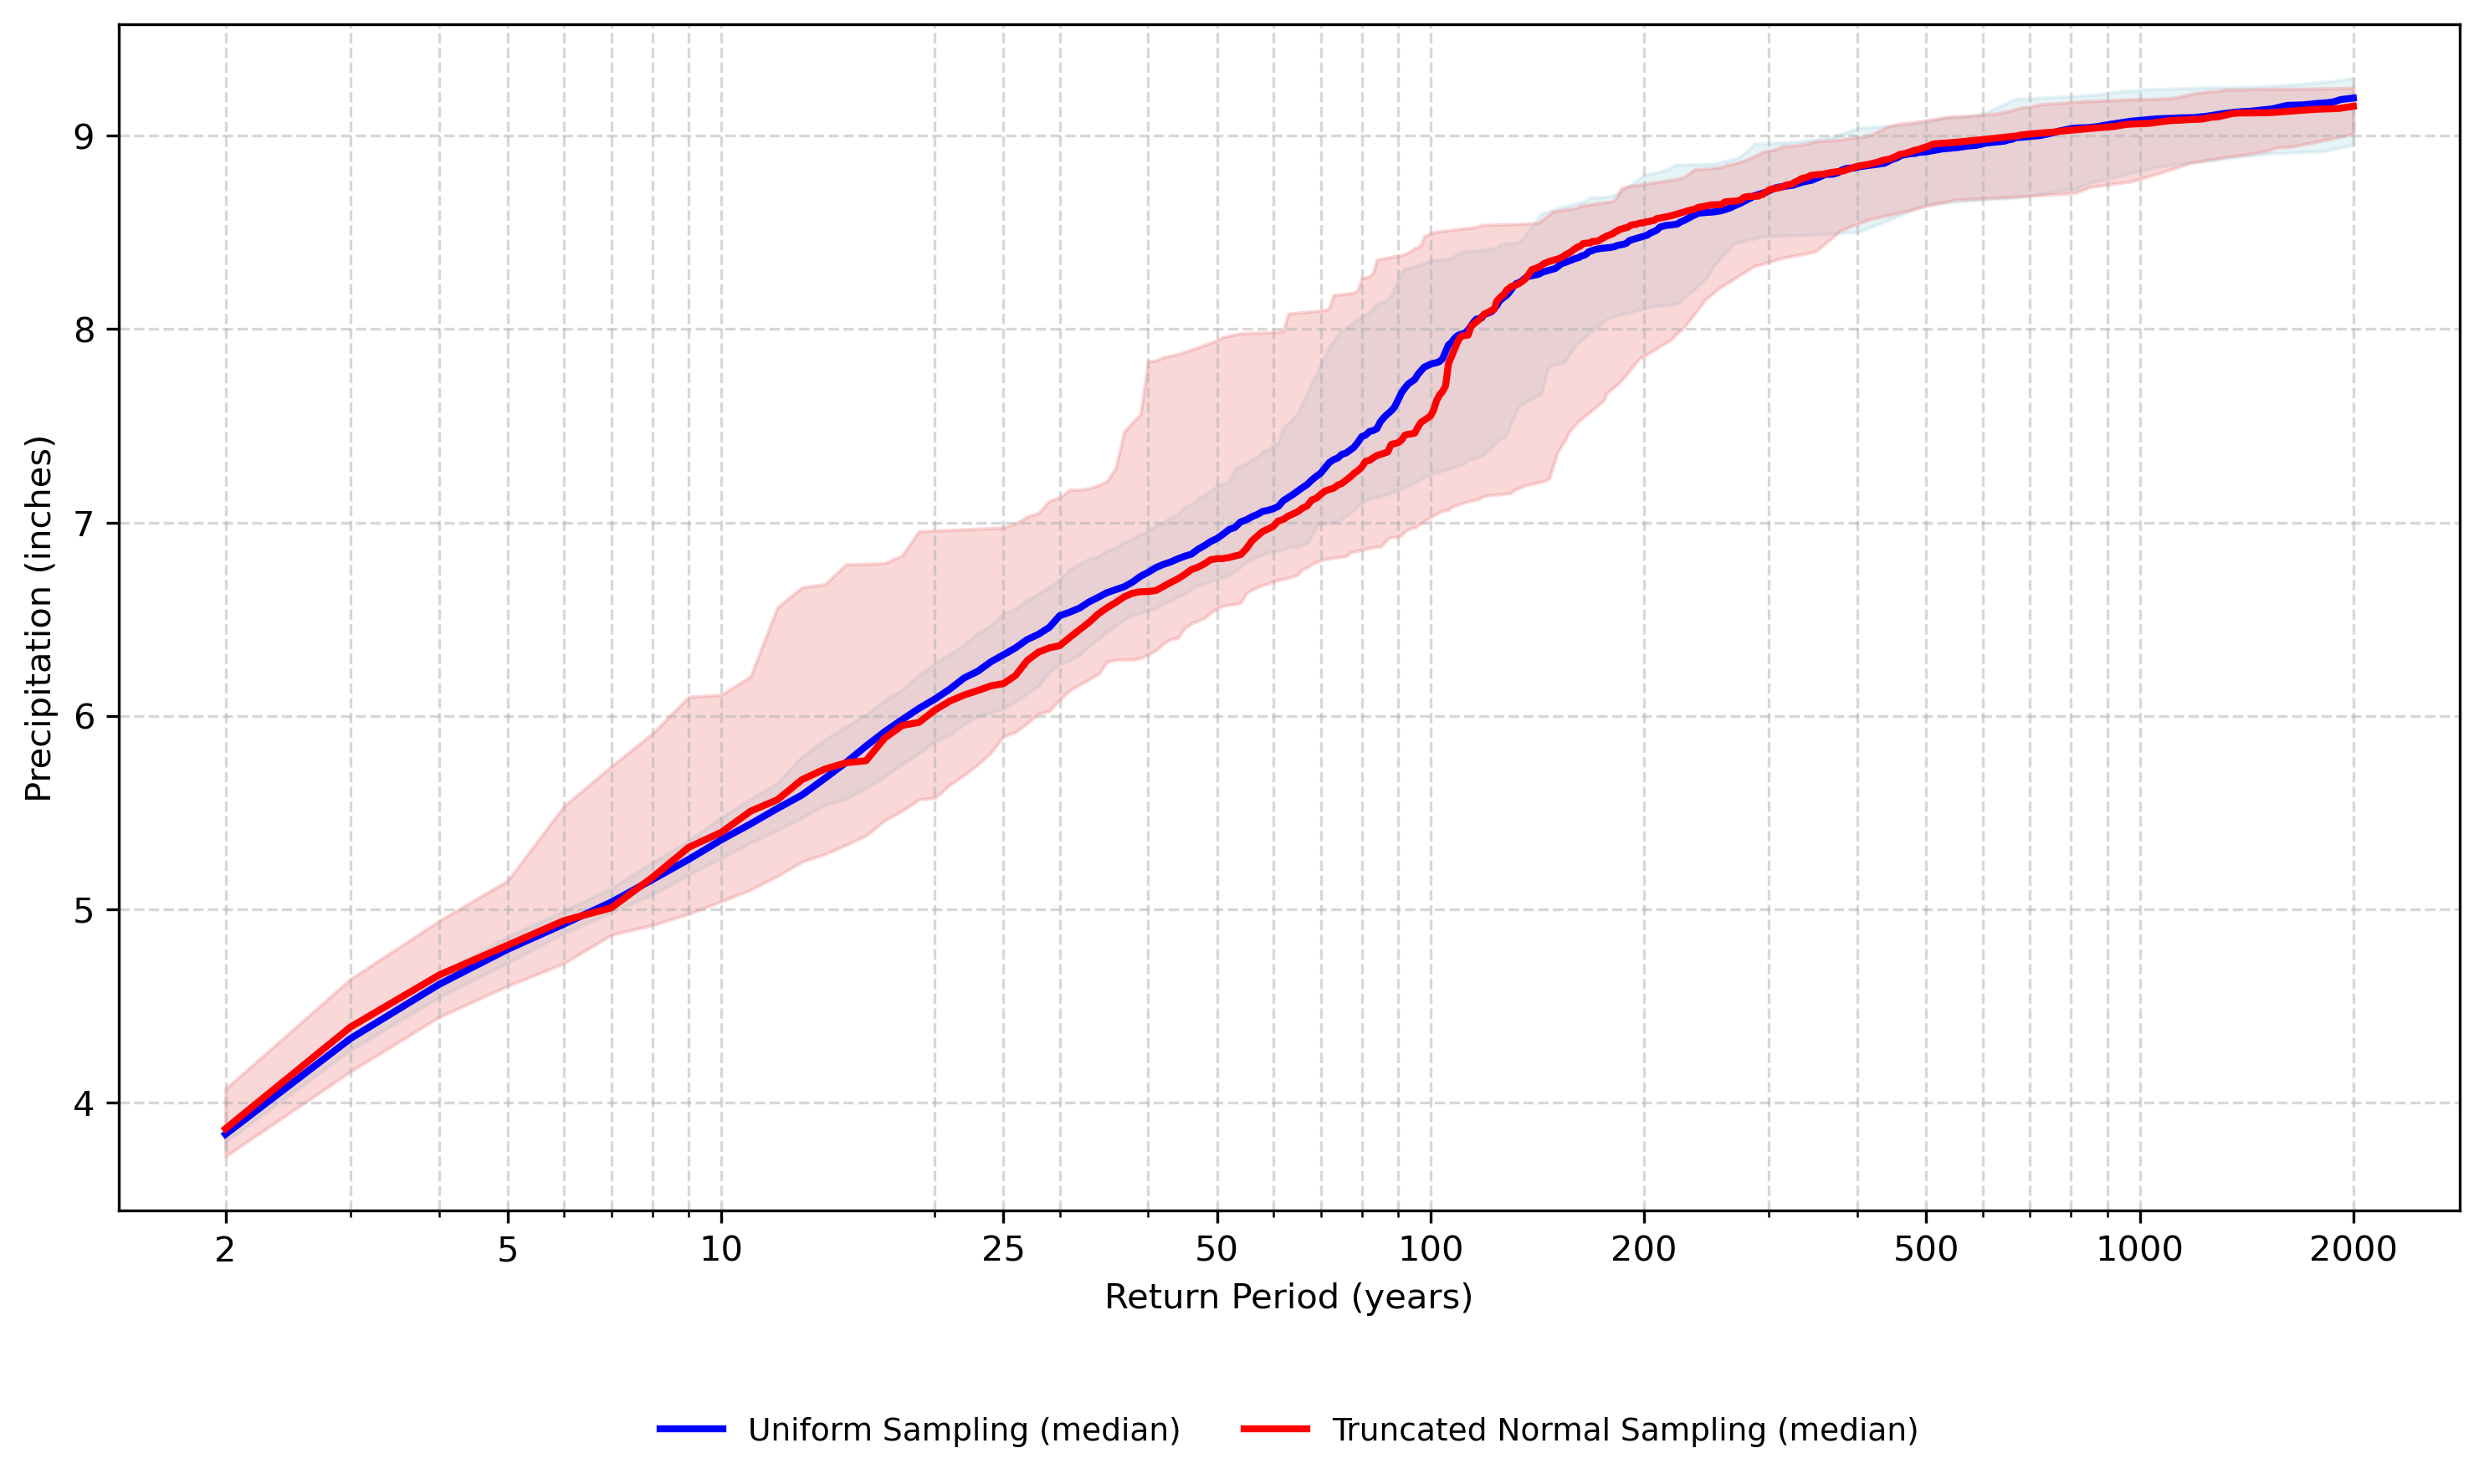

In [96]:
plot_two_return_period_summaries(
    summary1= summaries["Trinity"],          # your first summary DataFrame
    summary2=mixture_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Truncated Normal Sampling",
    title=""
)

Duwamish

In [97]:
watershed = watersheds["Duwamish"]

In [134]:
#Sample
params = {
    "mu_x_narrow": watershed.watershed_stats["x"],  
    "mu_y_narrow": watershed.watershed_stats["y"],
    "mu_x_wide": watershed.domain_stats["x"],  
    "mu_y_wide": watershed.domain_stats["y"],
    "sd_x_narrow": watershed.watershed_stats["range_x"]*0.2,
    "sd_y_narrow": watershed.watershed_stats["range_y"]*0.2,
    "sd_x_wide": watershed.domain_stats["range_x"],
    "sd_y_wide": watershed.domain_stats["range_y"],
    "mix": 0.6,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=6_000,
    num_realizations=50,
)

mixture_samples = sampler.sample(data = watershed)

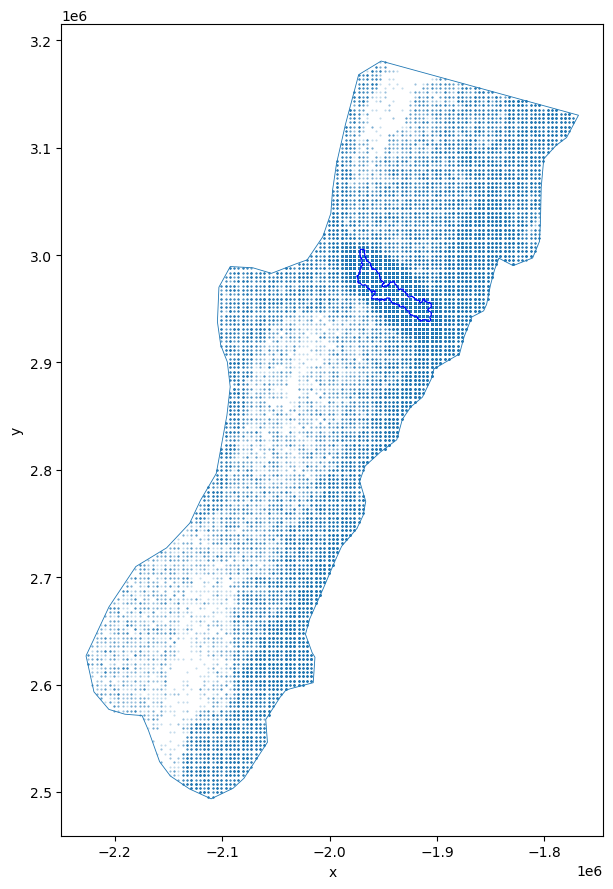

In [135]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
watershed.watershed_gdf.boundary.plot(ax=ax, linewidth=0.8, color='blue', label='Watershed')
plt.scatter(mixture_samples.newx, mixture_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [136]:
mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

In [137]:
mixture_summary = summarize_depths_by_return_period(
    df=mixture_depths,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
)

In [138]:
m = metrics(summaries["Duwamish"],mixture_summary)
m

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_low,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high
0,1999,2.0,2000.0,0.626236,0.642609,0.24829,1.321721,0.282778,1.032935,-0.5483,...,-0.211751,-1.036289,-0.2634,-0.8309,-1.088073,-1.358062,-0.071699,-1.480241,-0.101012,-1.665251


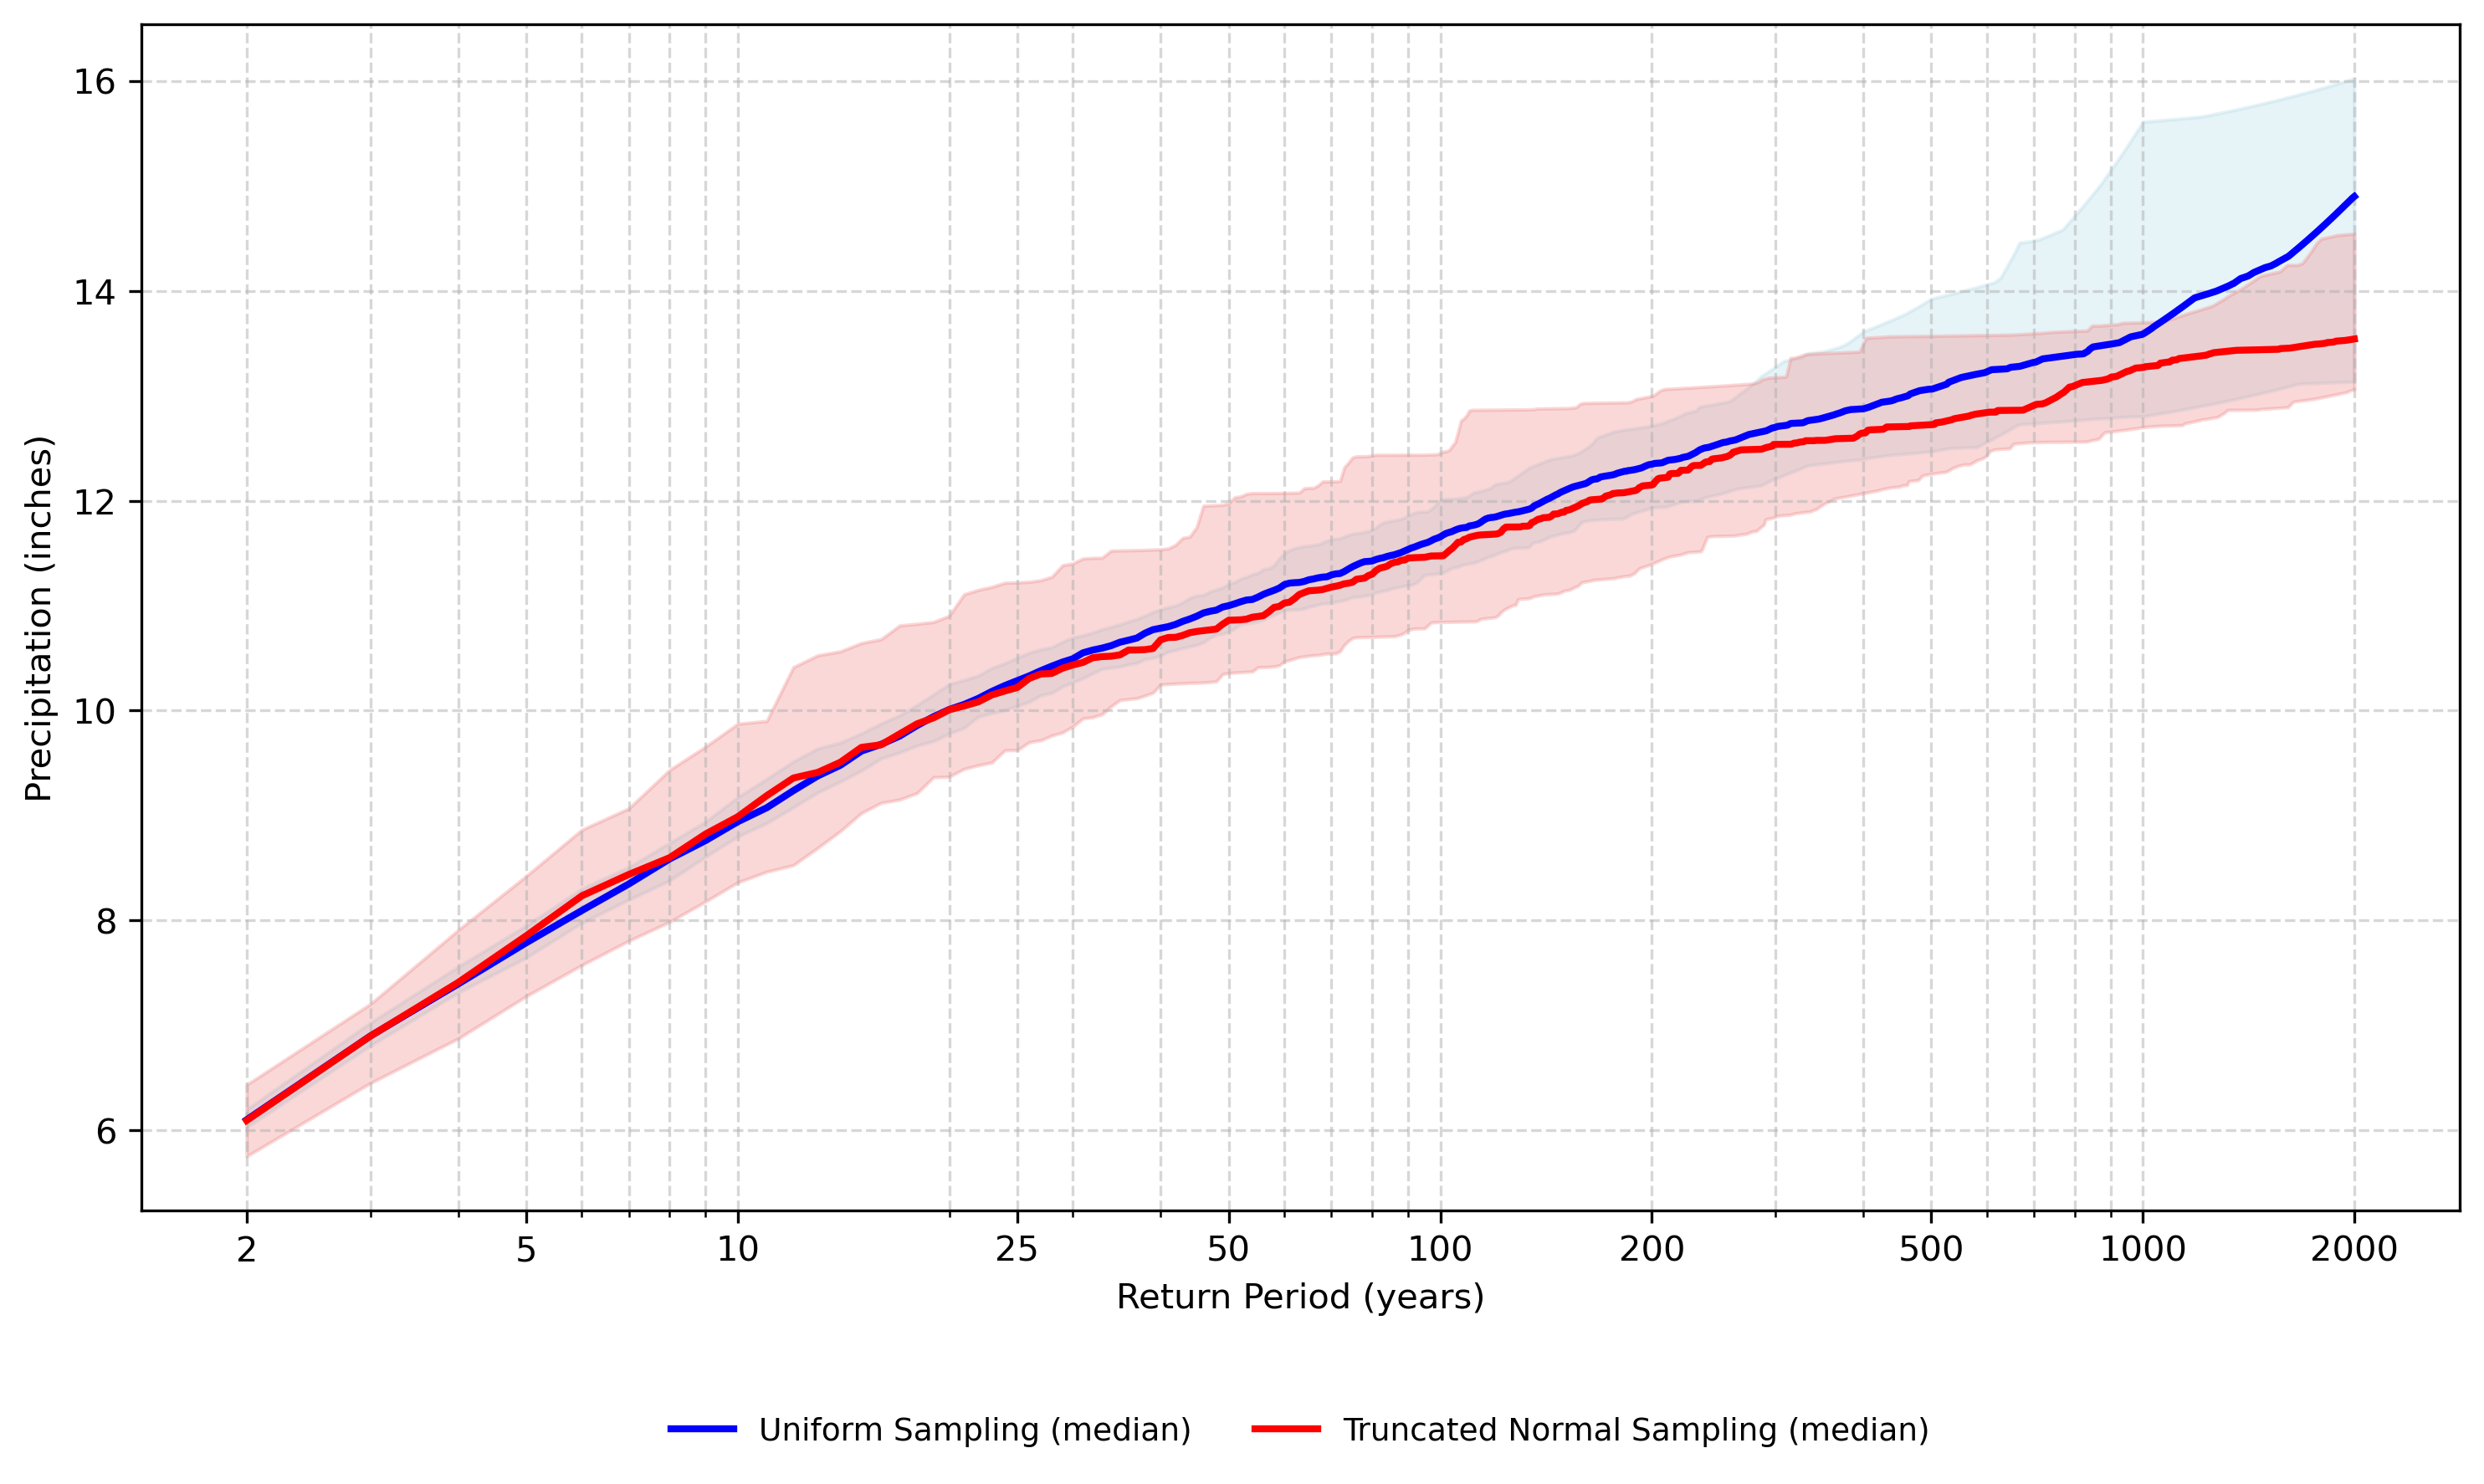

In [139]:
plot_two_return_period_summaries(
    summary1= summaries["Duwamish"],          # your first summary DataFrame
    summary2=mixture_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Truncated Normal Sampling",
    title=""
)

Kanawha

In [140]:
watershed = watersheds["Kanawha"]

In [159]:
#Sample
params = {
    "mu_x_narrow": watershed.watershed_stats["x"],  
    "mu_y_narrow": watershed.watershed_stats["y"],
    "mu_x_wide": watershed.domain_stats["x"],  
    "mu_y_wide": watershed.domain_stats["y"],
    "sd_x_narrow": watershed.watershed_stats["range_x"]*0.2,
    "sd_y_narrow": watershed.watershed_stats["range_y"]*0.3,
    "sd_x_wide": watershed.domain_stats["range_x"],
    "sd_y_wide": watershed.domain_stats["range_y"],
    "mix": 0.8,
    "rho_narrow": -0.1,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=6_000,
    num_realizations=50,
)

mixture_samples = sampler.sample(data = watershed)

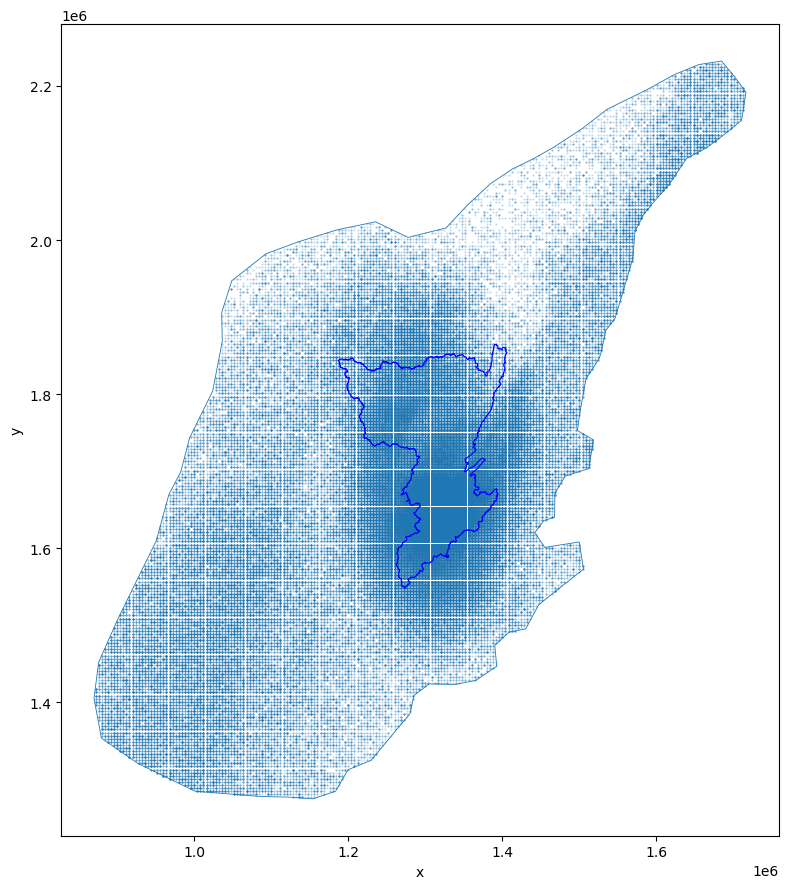

In [160]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
watershed.watershed_gdf.boundary.plot(ax=ax, linewidth=0.8, color='blue', label='Watershed')
plt.scatter(mixture_samples.newx, mixture_samples.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [161]:
mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

In [162]:
mixture_summary = summarize_depths_by_return_period(
    df=mixture_depths,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
)

In [163]:
m = metrics(summaries["Kanawha"],mixture_summary)
m

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_low,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high
0,1999,2.0,2000.0,0.019941,0.020786,0.073986,0.033466,0.034562,0.029936,-0.007797,...,0.039671,-0.025538,-0.001898,-0.022901,-0.001669,-0.003988,0.023636,-0.037816,0.009666,-0.040659


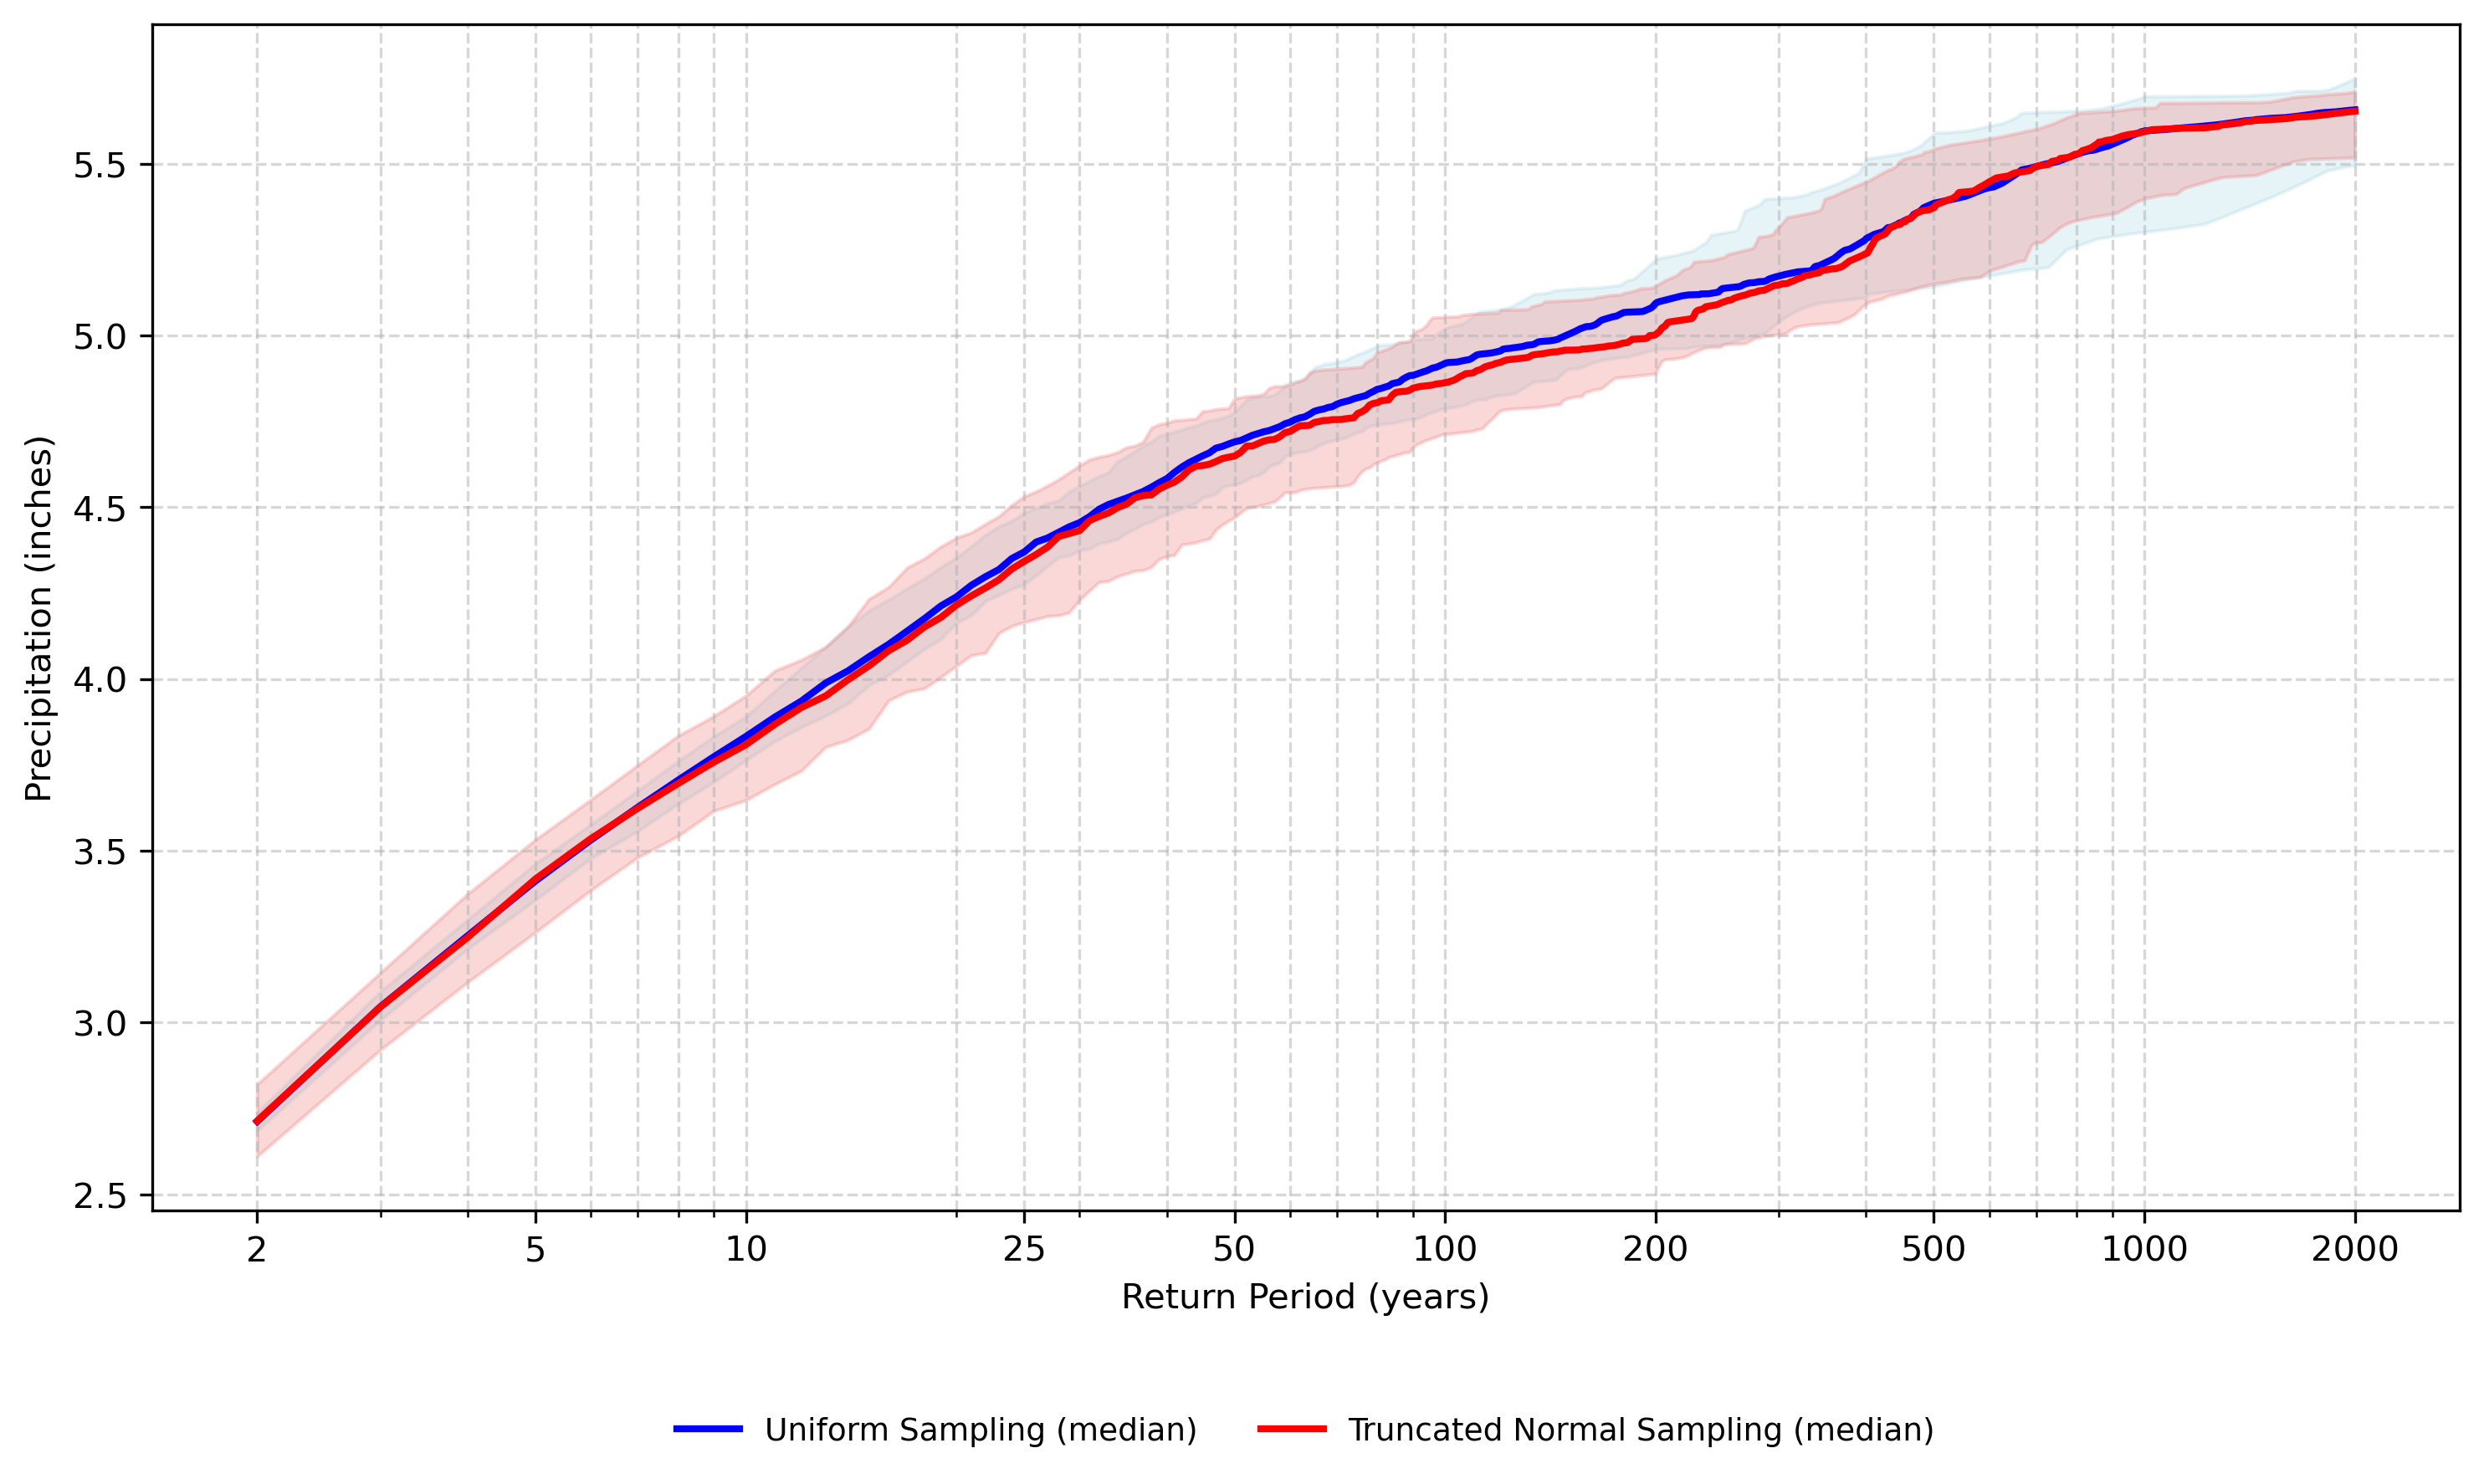

In [164]:
plot_two_return_period_summaries(
    summary1= summaries["Kanawha"],          # your first summary DataFrame
    summary2=mixture_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Truncated Normal Sampling",
    title=""
)

Combined

In [ ]:
watershed_name = "Trinity"
watershed = watersheds[watershed_name]

# ----- fixed sampler params -----
params = {
    "mu_x_narrow": float(watershed.watershed_stats["x"]),
    "mu_y_narrow": float(watershed.watershed_stats["y"]),
    "mu_x_wide":   float(watershed.domain_stats["x"]),
    "mu_y_wide":   float(watershed.domain_stats["y"]),
    "sd_x_narrow": float(watershed.watershed_stats["range_x"])*0.2,
    "sd_y_narrow": float(watershed.watershed_stats["range_y"])*0.2,
    "sd_x_wide":   float(watershed.domain_stats["range_x"]),
    "sd_y_wide":   float(watershed.domain_stats["range_y"]),
    "mix": 0.85,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

# where to save depths
out_dir = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}"
os.makedirs(out_dir, exist_ok=True)

# baseline obs/target summary to compare against
baseline_summary = summaries[watershed_name]

metrics_rows = []

for ns in (6_000, 8_000,10_000,12_000,14_000,16_000):
    # ---- sample ----
    sampler = ImportanceSampler(
        distribution="mixture_trunc_gauss",
        params=params,
        num_simulations=ns,
        num_realizations=50,   # keep fixed
    )
    mixture_samples = sampler.sample(data=watershed)

    # ---- depths ----
    mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

    # save depths parquet
    depths_path = os.path.join(out_dir, f"mixture_depths_ns{ns}.pq")
    mixture_depths.to_parquet(depths_path, index=False)

    # ---- summarize ----
    mixture_summary = summarize_depths_by_return_period(
        df=mixture_depths,
        precip_col="precip_avg_mm",
        exc_col="exc_prb",
        realization_col="realization",
        k=10.0,
        rp_min=2,
        rp_max_cap=2000,
    )

    # ---- metrics vs baseline ----
    m = metrics(baseline_summary, mixture_summary)
    m["num_simulations"] = ns
    metrics_rows.append(m)

# final metrics table
metrics_table = pd.concat(metrics_rows, ignore_index=True)
metrics_table
metrics_path = os.path.join(out_dir, f"metrics.pq")
metrics_table.to_parquet(metrics_path, index=False)


,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high,num_simulations
0,1999,2.0,2000.0,0.022176,0.044219,0.085455,0.139154,0.073469,0.117894,-0.014297,...,0.017078,-0.004371,0.012907,-0.037377,-0.057395,-0.014959,-0.036957,-0.019354,-0.033618,6000
1,1999,2.0,2000.0,0.041380,0.043298,0.102908,0.128540,0.082368,0.095061,-0.035792,...,-0.016871,-0.047056,-0.021262,-0.025924,-0.032834,-0.019419,-0.029799,-0.003148,-0.034691,8000
2,1999,2.0,2000.0,0.058837,0.063379,0.160139,0.107064,0.153220,0.085120,-0.033300,...,-0.011771,-0.016728,-0.036981,-0.026412,-0.041669,0.049479,-0.023487,0.041028,-0.053178,10000
3,1999,2.0,2000.0,0.033780,0.054779,0.112056,0.142088,0.108231,0.119068,-0.023276,...,-0.044707,0.036916,-0.048989,-0.019710,-0.051295,0.054110,-0.040837,0.063514,-0.058167,12000
4,1999,2.0,2000.0,0.021568,0.032830,0.089370,0.098092,0.085119,0.083032,-0.014989,...,-0.034040,0.035284,-0.040098,-0.021191,-0.037930,0.042619,-0.036111,0.046269,-0.031266,14000
5,1999,2.0,2000.0,0.036121,0.057487,0.102926,0.135587,0.093453,0.122144,-0.033484,...,-0.059156,0.034702,-0.062414,-0.030909,-0.055933,0.063779,-0.064556,0.068006,-0.065473,16000


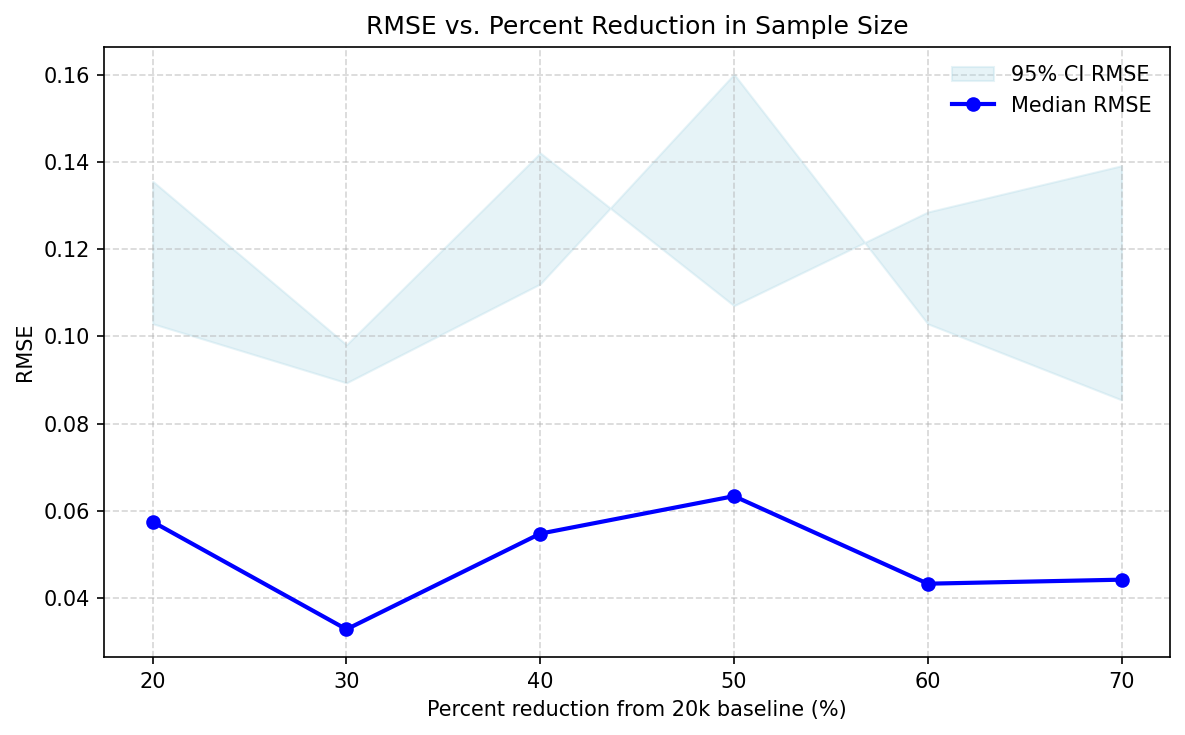

In [171]:
baseline = 20_000  # baseline number of samples

# Suppose metrics_table has columns:
# 'num_simulations','RMSE_median','RMSE_ci95_low','RMSE_ci95_high'
x_raw = metrics_table["num_simulations"].values

# compute percent reduction relative to baseline
x_pct_reduction = (baseline - x_raw) / baseline * 100.0

rmse_med = metrics_table["rmse_median"].values
rmse_low = metrics_table["rmse_ci95_low"].values
rmse_high = metrics_table["rmse_ci95_high"].values

plt.figure(figsize=(8,5), dpi=150)

# ribbon
plt.fill_between(x_pct_reduction, rmse_low, rmse_high,
                 color="lightblue", alpha=0.3,
                 label="95% CI RMSE")

# median RMSE line
plt.plot(x_pct_reduction, rmse_med, "-o", color="blue", lw=2, label="Median RMSE")

plt.xlabel("Percent reduction from 20k baseline (%)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Percent Reduction in Sample Size")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [190]:
watershed_name = "Duwamish"
watershed = watersheds[watershed_name]

# ----- fixed sampler params -----
params = {
    "mu_x_narrow": float(watershed.watershed_stats["x"]),
    "mu_y_narrow": float(watershed.watershed_stats["y"]),
    "mu_x_wide":   float(watershed.domain_stats["x"]),
    "mu_y_wide":   float(watershed.domain_stats["y"]),
    "sd_x_narrow": float(watershed.watershed_stats["range_x"])*0.5,
    "sd_y_narrow": float(watershed.watershed_stats["range_y"])*0.5,
    "sd_x_wide":   float(watershed.domain_stats["range_x"]),
    "sd_y_wide":   float(watershed.domain_stats["range_y"]),
    "mix": 0.8,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

# where to save depths
out_dir = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}"
os.makedirs(out_dir, exist_ok=True)

# baseline obs/target summary to compare against
baseline_summary = summaries[watershed_name]

metrics_rows = []

for ns in (6_000, 8_000,10_000,12_000,14_000,16_000):
    # ---- sample ----
    sampler = ImportanceSampler(
        distribution="mixture_trunc_gauss",
        params=params,
        num_simulations=ns,
        num_realizations=50,   # keep fixed
    )
    mixture_samples = sampler.sample(data=watershed)

    # ---- depths ----
    mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

    # save depths parquet
    depths_path = os.path.join(out_dir, f"mixture_depths_ns{ns}.pq")
    mixture_depths.to_parquet(depths_path, index=False)

    # ---- summarize ----
    mixture_summary = summarize_depths_by_return_period(
        df=mixture_depths,
        precip_col="precip_avg_mm",
        exc_col="exc_prb",
        realization_col="realization",
        k=10.0,
        rp_min=2,
        rp_max_cap=2000,
    )

    # ---- metrics vs baseline ----
    m = metrics(baseline_summary, mixture_summary)
    m["num_simulations"] = ns
    metrics_rows.append(m)

# final metrics table
metrics_table = pd.concat(metrics_rows, ignore_index=True)
metrics_table
metrics_path = os.path.join(out_dir, f"metrics.pq")
metrics_table.to_parquet(metrics_path, index=False)

In [196]:
metrics_table

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high,num_simulations
0,1999,2.0,2000.0,0.586637,0.605664,0.227222,1.163392,0.255913,0.963034,-0.543959,...,-0.985975,-0.234344,-0.832801,-0.965953,-1.212020,-0.175523,-1.244049,-0.055942,-1.499459,6000
1,1999,2.0,2000.0,0.626875,0.623728,0.242452,1.453898,0.275210,1.163580,-0.568476,...,-1.133042,-0.260083,-0.906555,-1.041075,-1.243728,-0.092297,-1.820077,-0.150433,-1.844337,8000
2,54,2.0,55.0,0.022938,0.084318,0.407718,0.785666,0.372706,0.580847,-0.010492,...,0.719593,-0.369035,0.548251,0.040077,-0.103345,-0.350562,1.694184,-0.386994,0.632029,10000
3,1999,2.0,2000.0,0.585856,0.587715,0.165181,1.529967,0.215608,1.230223,-0.522169,...,-1.241055,-0.150445,-1.021080,-0.972827,-1.223702,0.155757,-1.848553,0.170878,-1.956840,12000
4,74,2.0,75.0,0.058467,0.069913,0.408753,0.834334,0.364137,0.665983,0.018298,...,0.723862,-0.356419,0.584107,0.168414,-0.077414,-0.380757,2.251362,-0.328377,1.464243,14000
5,84,2.0,85.0,0.045787,0.040913,0.272674,0.732320,0.258336,0.561973,0.034204,...,0.690861,-0.247377,0.539897,0.104849,0.030412,-0.082493,1.343287,-0.154302,0.752561,16000


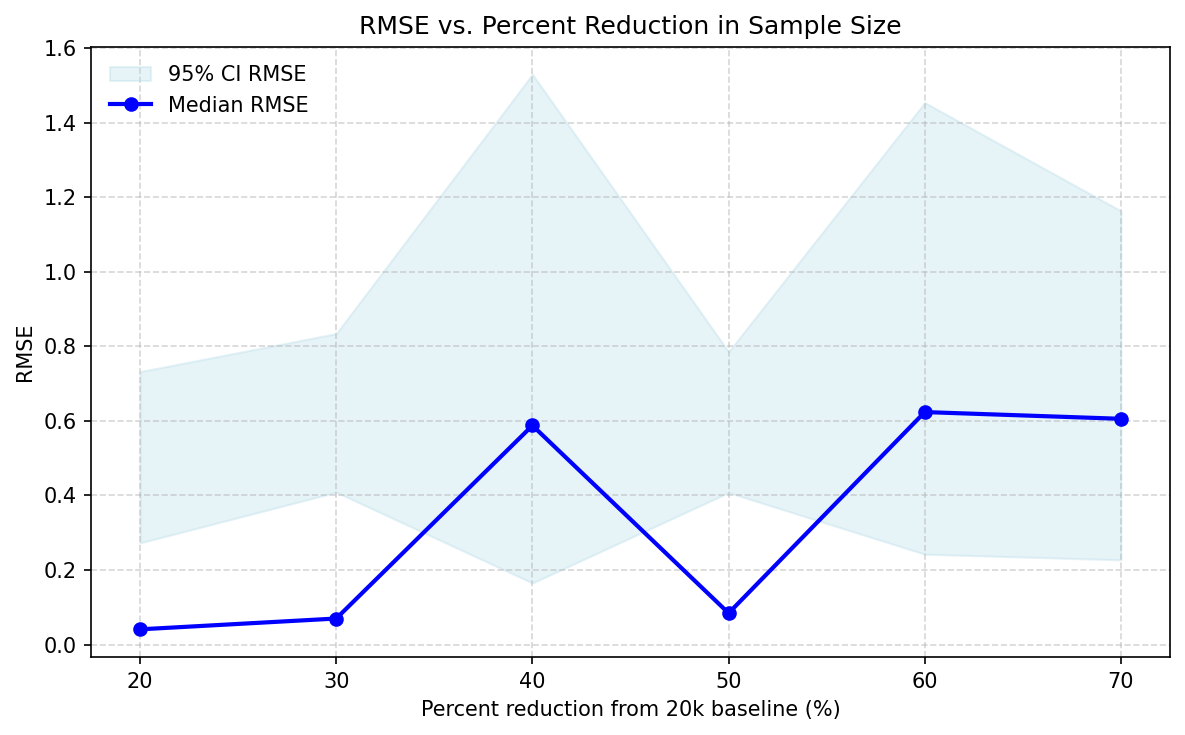

In [195]:
metrics_table = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/Duwamish/metrics.pq")
baseline = 20_000  # baseline number of samples

# Suppose metrics_table has columns:
# 'num_simulations','RMSE_median','RMSE_ci95_low','RMSE_ci95_high'
x_raw = metrics_table["num_simulations"].values

# compute percent reduction relative to baseline
x_pct_reduction = (baseline - x_raw) / baseline * 100.0

rmse_med = metrics_table["rmse_median"].values
rmse_low = metrics_table["rmse_ci95_low"].values
rmse_high = metrics_table["rmse_ci95_high"].values

plt.figure(figsize=(8,5), dpi=150)

# ribbon
plt.fill_between(x_pct_reduction, rmse_low, rmse_high,
                 color="lightblue", alpha=0.3,
                 label="95% CI RMSE")

# median RMSE line
plt.plot(x_pct_reduction, rmse_med, "-o", color="blue", lw=2, label="Median RMSE")

plt.xlabel("Percent reduction from 20k baseline (%)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Percent Reduction in Sample Size")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [191]:
watershed_name = "Kanawha"
watershed = watersheds[watershed_name]

# ----- fixed sampler params -----
params = {
    "mu_x_narrow": float(watershed.watershed_stats["x"]),
    "mu_y_narrow": float(watershed.watershed_stats["y"]),
    "mu_x_wide":   float(watershed.domain_stats["x"]),
    "mu_y_wide":   float(watershed.domain_stats["y"]),
    "sd_x_narrow": float(watershed.watershed_stats["range_x"])*0.2,
    "sd_y_narrow": float(watershed.watershed_stats["range_y"])*0.3,
    "sd_x_wide":   float(watershed.domain_stats["range_x"]),
    "sd_y_wide":   float(watershed.domain_stats["range_y"]),
    "mix": 0.8,
    "rho_narrow": -0.1,
    "rho_wide":   0.1,
}

# where to save depths
out_dir = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}"
os.makedirs(out_dir, exist_ok=True)

# baseline obs/target summary to compare against
baseline_summary = summaries[watershed_name]

metrics_rows = []

for ns in (6_000, 8_000,10_000,12_000,14_000,16_000):
    # ---- sample ----
    sampler = ImportanceSampler(
        distribution="mixture_trunc_gauss",
        params=params,
        num_simulations=ns,
        num_realizations=50,   # keep fixed
    )
    mixture_samples = sampler.sample(data=watershed)

    # ---- depths ----
    mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

    # save depths parquet
    depths_path = os.path.join(out_dir, f"mixture_depths_ns{ns}.pq")
    mixture_depths.to_parquet(depths_path, index=False)

    # ---- summarize ----
    mixture_summary = summarize_depths_by_return_period(
        df=mixture_depths,
        precip_col="precip_avg_mm",
        exc_col="exc_prb",
        realization_col="realization",
        k=10.0,
        rp_min=2,
        rp_max_cap=2000,
    )

    # ---- metrics vs baseline ----
    m = metrics(baseline_summary, mixture_summary)
    m["num_simulations"] = ns
    metrics_rows.append(m)

# final metrics table
metrics_table = pd.concat(metrics_rows, ignore_index=True)
metrics_table
metrics_path = os.path.join(out_dir, f"metrics.pq")
metrics_table.to_parquet(metrics_path, index=False)

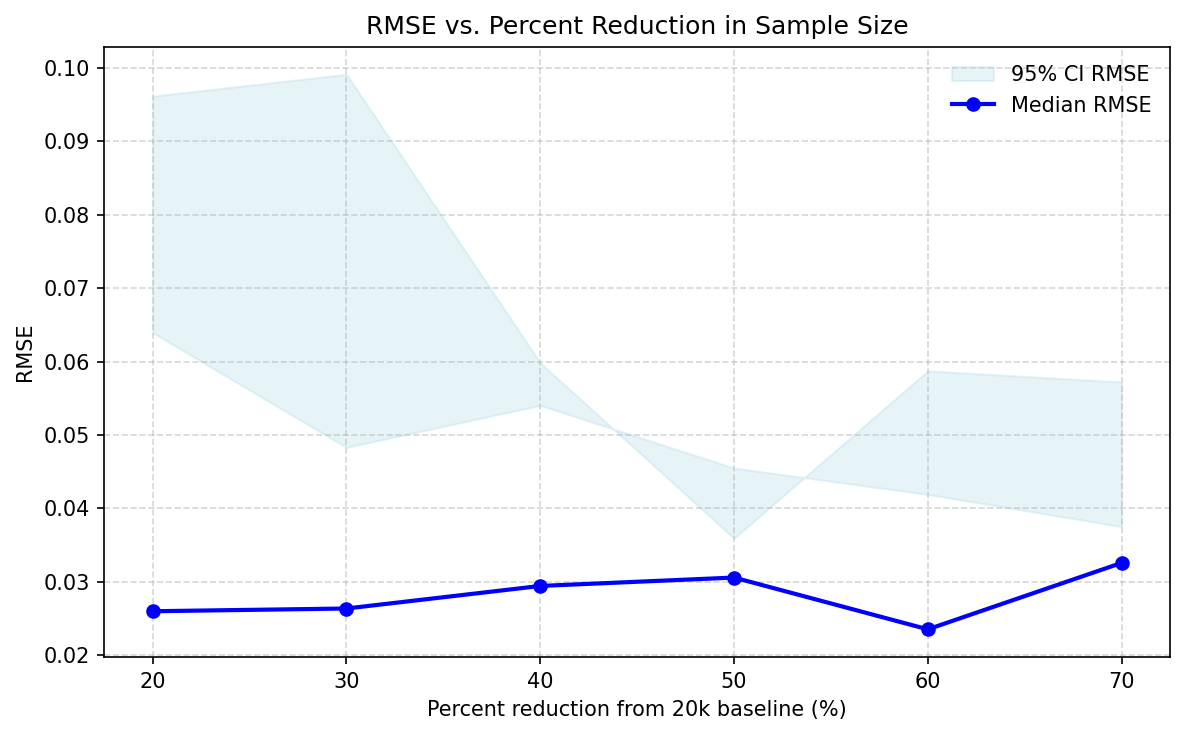

In [194]:
baseline = 20_000  # baseline number of samples

# Suppose metrics_table has columns:
# 'num_simulations','RMSE_median','RMSE_ci95_low','RMSE_ci95_high'
x_raw = metrics_table["num_simulations"].values

# compute percent reduction relative to baseline
x_pct_reduction = (baseline - x_raw) / baseline * 100.0

rmse_med = metrics_table["rmse_median"].values
rmse_low = metrics_table["rmse_ci95_low"].values
rmse_high = metrics_table["rmse_ci95_high"].values

plt.figure(figsize=(8,5), dpi=150)

# ribbon
plt.fill_between(x_pct_reduction, rmse_low, rmse_high,
                 color="lightblue", alpha=0.3,
                 label="95% CI RMSE")

# median RMSE line
plt.plot(x_pct_reduction, rmse_med, "-o", color="blue", lw=2, label="Median RMSE")

plt.xlabel("Percent reduction from 20k baseline (%)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Percent Reduction in Sample Size")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Denton

In [238]:
watershed_name = "Denton"
watershed = watersheds[watershed_name]

# ----- fixed sampler params -----
params = {
    "mu_x_narrow": float(watershed.watershed_stats["x"]),
    "mu_y_narrow": float(watershed.watershed_stats["y"]),
    "mu_x_wide":   float(watershed.domain_stats["x"]),
    "mu_y_wide":   float(watershed.domain_stats["y"]),
    "sd_x_narrow": float(watershed.watershed_stats["range_x"])*1.5,
    "sd_y_narrow": float(watershed.watershed_stats["range_y"])*1.5,
    "sd_x_wide":   float(watershed.domain_stats["range_x"]),
    "sd_y_wide":   float(watershed.domain_stats["range_y"]),
    "mix": 0.85,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

# where to save depths
out_dir = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}"
os.makedirs(out_dir, exist_ok=True)

# baseline obs/target summary to compare against
baseline_summary = summaries[watershed_name]

metrics_rows = []

for ns in (1_000,6_000):
    # ---- sample ----
    sampler = ImportanceSampler(
        distribution="mixture_trunc_gauss",
        params=params,
        num_simulations=ns,
        num_realizations=50,   # keep fixed
    )
    mixture_samples = sampler.sample(data=watershed)

    # ---- depths ----
    mixture_depths = StormDepthProcessor(watershed).run(mixture_samples, n_jobs=-1)

    # save depths parquet
    depths_path = os.path.join(out_dir, f"mixture_depths_ns{ns}.pq")
    mixture_depths.to_parquet(depths_path, index=False)

    # ---- summarize ----
    mixture_summary = summarize_depths_by_return_period(
        df=mixture_depths,
        precip_col="precip_avg_mm",
        exc_col="exc_prb",
        realization_col="realization",
        k=10.0,
        rp_min=2,
        rp_max_cap=2000,
    )

    # ---- metrics vs baseline ----
    m = metrics(baseline_summary, mixture_summary)
    m["num_simulations"] = ns
    metrics_rows.append(m)

# final metrics table
metrics_table = pd.concat(metrics_rows, ignore_index=True)
metrics_table
metrics_path = os.path.join(out_dir, f"metrics.pq")
metrics_table.to_parquet(metrics_path, index=False)


In [243]:
watershed_name = "Denton"
watershed = watersheds[watershed_name]

# ----- fixed sampler params -----
params = {
    "mu_x_narrow": float(watershed.watershed_stats["x"]),
    "mu_y_narrow": float(watershed.watershed_stats["y"]),
    "mu_x_wide":   float(watershed.domain_stats["x"]),
    "mu_y_wide":   float(watershed.domain_stats["y"]),
    "sd_x_narrow": float(watershed.watershed_stats["range_x"]),
    "sd_y_narrow": float(watershed.watershed_stats["range_y"]),
    "sd_x_wide":   float(watershed.domain_stats["range_x"]),
    "sd_y_wide":   float(watershed.domain_stats["range_y"]),
    "mix": 0.5,
    "rho_narrow": -0.7,
    "rho_wide":   0.1,
}

sampler = ImportanceSampler(
    distribution="mixture_trunc_gauss",
    params=params,
    num_simulations=6000,
    num_realizations=50,   # keep fixed
)
mixture_samples = sampler.sample(data=watershed)


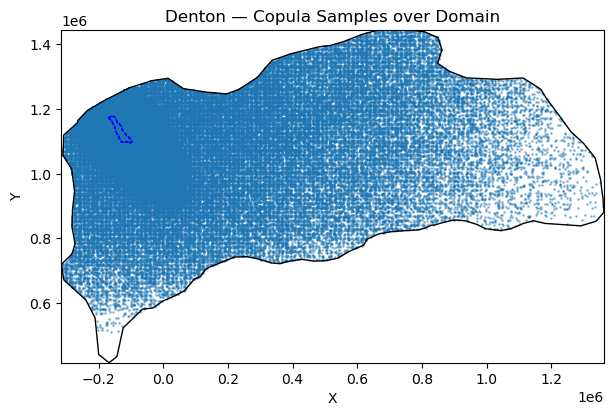

In [244]:
import matplotlib.pyplot as plt

# Plot domain and watershed boundaries
fig, ax = plt.subplots(figsize=(7,7))
watershed.domain_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
watershed.watershed_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=1, linestyle="--")

# Scatter all samples (x, y)
ax.scatter(
    mixture_samples["newx"].to_numpy(),
    mixture_samples["newy"].to_numpy(),
    s=1, alpha=0.4
)

# Nice axes and title
ax.set_aspect("equal", adjustable="box")
minx, miny, maxx, maxy = watershed.domain_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Denton — Copula Samples over Domain")
plt.show()

In [239]:
metrics_table

,n_points,rp_min_used,rp_max_used,rmse_mean,rmse_median,rmse_ci95_low,rmse_ci95_high,rmse_ci90_low,rmse_ci90_high,me_mean,...,me_ci95_high,me_ci90_low,me_ci90_high,diff_at_maxrp_mean,diff_at_maxrp_median,diff_at_maxrp_ci95_low,diff_at_maxrp_ci95_high,diff_at_maxrp_ci90_low,diff_at_maxrp_ci90_high,num_simulations
0,130,2.0,131.0,0.137244,0.327149,1.522751,5.462922,1.354224,3.507435,0.119040,...,5.161494,-1.269829,3.194561,0.128348,-0.646631,-2.075743,7.980678,-1.892369,6.136784,1000
1,1154,2.0,1155.0,0.340985,0.837617,0.541290,0.657601,0.563055,0.689410,0.160004,...,0.246234,-0.437926,0.304140,0.867419,1.554034,0.173935,0.679752,0.176033,0.121828,6000


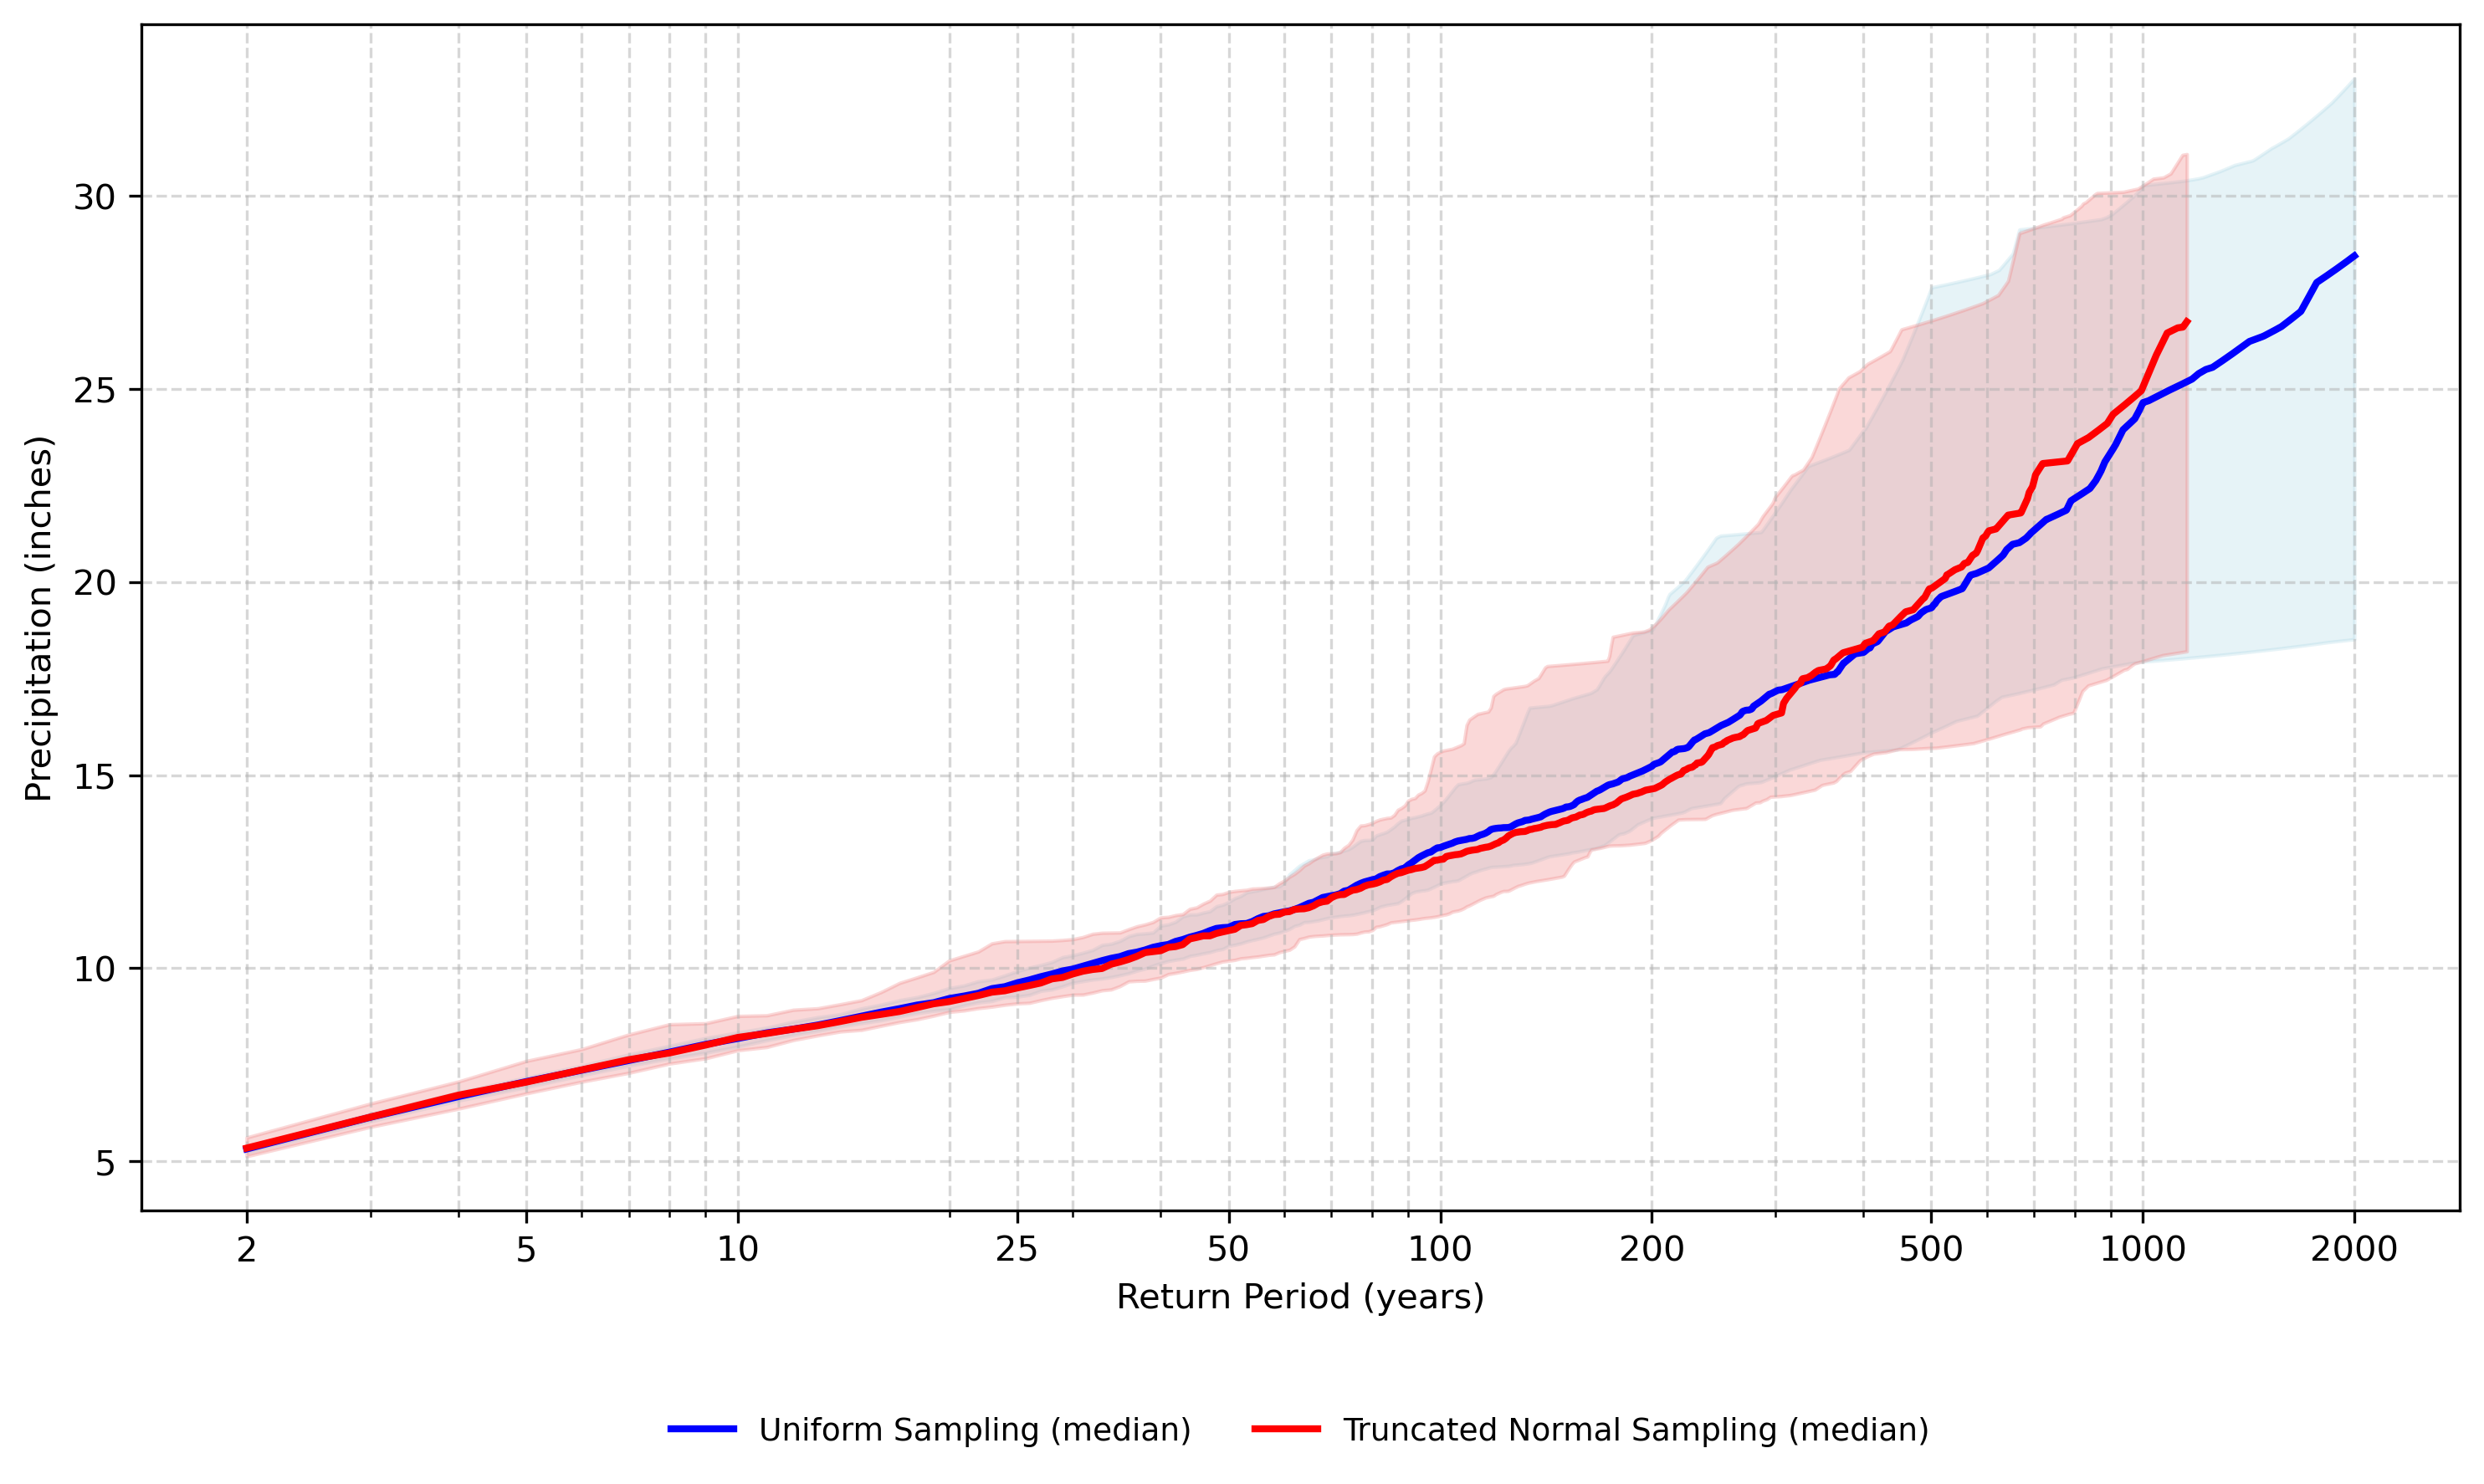

In [240]:
plot_two_return_period_summaries(
    summary1= summaries["Denton"],          # your first summary DataFrame
    summary2=mixture_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Truncated Normal Sampling",
    title=""
)

In [215]:
mixture_depths

,event_id,storm_path,x,y,weight,precip_avg_mm,realization,realization_seed,exc_prb
0,1,19821225_72hr_st1_r011,-117046.535275,1.121549e+06,1.520387e-06,276.634186,1,6.375900e+18,0.002808
1,2,20130223_72hr_st1_r186,-129046.535275,1.121549e+06,4.577436e-07,168.754379,1,6.375900e+18,0.029708
2,3,20020330_72hr_st1_r379,-121046.535275,1.125549e+06,2.758200e-06,104.834198,1,6.375900e+18,0.157317
3,4,19910525_72hr_st3_r174,-149046.535275,1.145549e+06,2.060067e-06,166.095642,1,6.375900e+18,0.030335
4,5,20010117_72hr_st1_r208,-161046.535275,1.157549e+06,5.504862e-06,115.402626,1,6.375900e+18,0.109564
...,...,...,...,...,...,...,...,...,...
299995,5996,19901007_72hr_st5_r329,-153046.535275,1.145549e+06,2.791847e-06,191.062317,50,1.190753e+19,0.015388
299996,5997,20180731_72hr_st3_r427,-129046.535275,1.101549e+06,1.149548e-06,99.118423,50,1.190753e+19,0.155559
299997,5998,20010117_72hr_st1_r208,-133046.535275,1.153549e+06,4.785660e-06,121.334206,50,1.190753e+19,0.077668
299998,5999,20001123_72hr_st1_r116,-165046.535275,1.141549e+06,2.998818e-05,116.123688,50,1.190753e+19,0.099664
